<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<center>
<H1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</H1>

<H3 align='center'> Tarea 2 - Redes Neuronales y *Deep Learning* </H3>
</center>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
#TF
import tensorflow as tf
#Keras
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Lambda,Input, Dense, Flatten, Reshape, Conv2D, Flatten, Dense, MaxPooling2D, UpSampling2D,Conv2DTranspose,Activation
from keras.models import Model, load_model

#sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, completeness_score, fowlkes_mallows_score
#scipy
from scipy.stats import norm
#IPython
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


> _**a) Normalice las imágenes de modo que los pixeles queden en el rango [0, 1] como se acostumbra al trabajar con imágenes. Visualice y comente sobre los datos a trabajar.**_

Se utilizará el conocido dataset _**mnist**_ para los siguientes experimentos. Este dataset contiene 60000 imágenes (10000 en el conjunto de pruebas) de 28 x 28 x 1, donde cada imagen contiene un dígito escrito a mano.

Tal como se acostumbra, se normalizan las imágenes de tal manera que queden en un rango de [0, 1]. Al estar trabajando con imágenes en escala de grises, se divide el valor de cada pixel por 255, dado que cada pixel solo tiene 256 valores posibles (del 0 al 255).

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows,img_cols,channel)

In [3]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [4]:
def show_9_random_images(dataset,labels):
    plt.figure(figsize=(12,12))
    for i in range(1,10):
        plt.subplot(3,3,i)
        random_index = np.random.randint(0,dataset.shape[0])
        plt.title("Label image %s" %labels[random_index])
        plt.imshow(dataset[random_index][:,:,0],cmap='gray')
        
    plt.show()    
        

A continuación se muestran 9 imágenes obtenidas desde el conjunto de entrenamiento, en conjunto al dígito que contiene cada imágen.

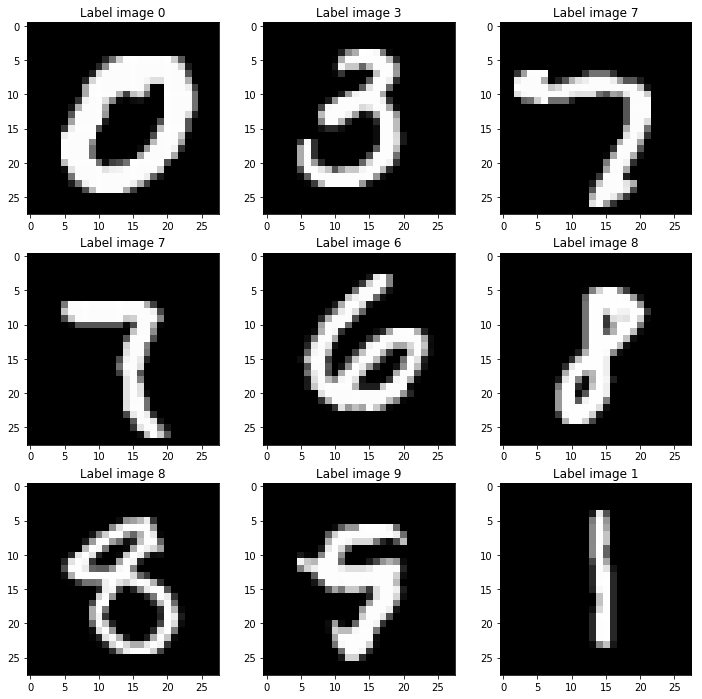

In [5]:
show_9_random_images(x_train,y_train)

Si bien las imágenes seleccionadas cambian según se vaya ejecutando la función, luego de un par de intentos se logra observar dígitos escritos de tal manera que podría engañar al desempeño humano, tal como 4 que lucen muy similares a un 9.

## Autoencoder clásico

Un Autoencoder es una técnica de aprendizaje no supervisado que permite encontrar una representación de menor dimensionalidad de su input con el objetivo de realizar transformaciones en este input. Estos se componen de dos partes: un Encoder, el cual lleva este input a una representación que le resulte útil para su tarea; y un Decoder, el cual toma dicha presentación y retorna el resultado esperado.

En este caso se utilizará un Autoencoder como un método de reducción de dimensionalidad, por lo que a partir de la imagen se buscará obtener una representación que contenga la información necesaria para retornar la imagen original (o algo cercano), con el objetivo de realizar clasificación sobre la representación reducida.

Otros usos de Autoencoders son la limpieza de ruido sobre una imagen o la coloración de estas, entre otras.

> _**a) Entrene un AE básico, 1 capa escondida feed forward, para generar una representación de MNIST en  $d^{'}=2,8,16,32$  dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación ReLU para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?**_

En este caso se entrenan distintos Autoencoder para generar una representación latente de 2, 8, 16 y 32 dimensiones. Como queremos obtener como salida el mismo input, el cual contiene imágenes con cada pixel normalizado entre [0, 1] necesitamos una función que logre medir las diferencias entre ambas imágenes, por lo que se podría usar Mean Squared Error para esta labor, dado que permite medir las diferencias pixel a pixel. Además, como nuestros pixeles están entre [0 , 1], podemos utilizar Binary Crossentropy al considerar cada pixel como una probabilidad. 

Por otro lado, la elección de la función de perdida también se puede ver desde el punto de vista de la formalización de un AutoEncoder general, donde se piensa que el encoder y decoder son probabilísticos. En dicho caso el criterio de entrenamiento utilizado es maximizar la información que captura la representación latente (z) del input (x), dando origen a las probabilidades condicionales $p(z|x)$ para el encoder y $p(x|z)$. Al optimizar la información mutua surge la siguiente expresión asociada tanto a encoder como decoder.

$$ E_{x} E_{z|x} p(z|x)ln(p(x|z)) + E_{x} ln(p(x))$$

Al no poder obtener $p(x)$, ni tampoco los valores esperados, se genera un criterio aproximado de entrenamiento:

$$ \frac{1}{n} \sum_{i=1}^{n}\sum_{z} p(z|x^{(i)})\cdot ln(p(x^{(i)}|z))$$

Como en el caso del autoencoder clásico la representación latente es determinista, el criterio anterior queda de la siguiente manera:

$$ \frac{1}{n} \sum_{i = 1}^{n} ln(p(x^{(i)}|h(x^{(i)}))$$

Con $h(x)$ la función implementada por el encoder. 

En este punto se debe tomar una decisión con respecto al decoder, pues asumiendo que es probabilístico es posible encontrar la Loss Function a utilizar. Si se asume que $g(h(x))$, la función que implementa el decoder, sigue una distribución gaussiana la la función de pérdida a utilizar es el Mean Squared Error. En cambio, si se asume que la función que implementa el decoder es binaria con respecto a los datos, la función de perdida a utilizar es Binary Crossentropy. En este caso se considerará que ambas son posibles. 

Dado lo anterior, se utilizarán ambas funciones de pérdidas. Además, se probará con una activación sigmoidal y una activación ReLu para el encoder y una activación sigmoidal para el decoder, debido que no se debería utilizar una activación ReLu en el decoder, pues podría producir pixeles con un valor mayor a 1.

Para cada AE se mide el porcentaje de compresión y el error de reconstrucción.

In [5]:
def get_basic_autoencoder(compres_dim=2,activation_encoder='sigmoid',activation_decoder='sigmoid',loss='binary_crossentropy'):
    input_img = Input(shape=original_img_size)
    flatten_input = Flatten()(input_img)
    encoder = Dense(compres_dim,activation=activation_encoder)(flatten_input)
    decoder = Dense(np.prod(original_img_size),activation=activation_decoder)(encoder)
    decoder = Reshape(original_img_size)(decoder)
    autoencoder = Model(inputs=input_img,outputs=decoder)
    autoencoder.compile(optimizer='rmsprop',loss=loss)
    encoder = Model(inputs=input_img,outputs=encoder)
    test_loss = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,verbose=0,validation_data=(x_test,x_test)).history['val_loss']
    return autoencoder, encoder, test_loss

def train_and_save_autoencoders(dimension_list,activation_encoder,activation_decoder,loss):
    hist_list = []
    for i in dimension_list:
        autoencoder, encoder, test_loss = get_basic_autoencoder(compres_dim=i,activation_encoder=activation_encoder,activation_decoder=activation_decoder,loss=loss)
        hist_list.append(test_loss)
        autoencoder.save('autoencoders/basic_autoencoders/%s/%s_autoencoder_d%s.h5' % (loss,activation_encoder,i))
        encoder.save('autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5' % (loss,activation_encoder,i))
    return hist_list
        

###### Usando Binary Crossentropy 

In [6]:
dimension_list = [2,8,16,32]
#Run only one time c:

```python
autoencoder_hist_list = train_and_save_autoencoders(dimension_list,'sigmoid','sigmoid','binary_crossentropy')
```

```python
autoencoder_hist_list_relu = train_and_save_autoencoders(dimension_list,'relu','sigmoid','binary_crossentropy')
```

##### Usando Mean Squared Error

```python
autoencoder_hist_list_mse = train_and_save_autoencoders(dimension_list,'sigmoid','sigmoid','mean_squared_error')
```

```python
autoencoder_hist_list_mse_relu = train_and_save_autoencoders(dimension_list,'relu','sigmoid','mean_squared_error')
```

###### Guardamos las historias en dos diccionarios

```python
AE_sigmoid_dict = {
    'binary_crossentropy':autoencoder_hist_list,
    'mean_squared_error':autoencoder_hist_list_mse
}
AE_relu_dict = {
    'binary_crossentropy':autoencoder_hist_list_relu,
    'mean_squared_error':autoencoder_hist_list_mse_relu
}
```

```python
with open('autoencoders/basic_autoencoders/hist_dicts/AE_sigmoid_dict.sav','wb') as handler:
    pickle.dump(AE_sigmoid_dict, handler)
```

```python
with open('autoencoders/basic_autoencoders/hist_dicts/AE_relu_dict.sav','wb') as handler:
    pickle.dump(AE_relu_dict, handler)
```

##### Cargar las historias

In [7]:
pickle_in = open("autoencoders/basic_autoencoders/hist_dicts/AE_sigmoid_dict.sav","rb")
pickle_in_relu =  open("autoencoders/basic_autoencoders/hist_dicts/AE_relu_dict.sav","rb")
AE_sigmoid_dict = pickle.load(pickle_in)
AE_relu_dict = pickle.load(pickle_in_relu)
pickle_in.close()
pickle_in_relu.close()

###### Error de reconstrucción

In [8]:
def reconstruction_error_plot(dim_list, activation_encoder, hist_dict, hist_dict_relu):
    plt.figure(figsize=(15,7))
    counter = 1
    #marker_list = ['-o','-*','-h','-s']
    sig_loss = list()
    relu_loss = list()
    for loss in hist_dict.keys():
        plt.subplot(1,2,counter)
        plt.title("Reconstruction error using %s" %loss,fontsize=18)
        plt.xlabel("error",fontsize=15)
        plt.ylabel("Dimension",fontsize=15)
        hist_list = hist_dict[loss]
        hist_list_relu = hist_dict_relu[loss]
        val_loss_list = list()
        val_loss_list_relu = list()
        for index in range(len(dim_list)):
            val_loss_list.append(hist_list[index][-1])
            val_loss_list_relu.append(hist_list_relu[index][-1])
        plt.barh(dim_list,val_loss_list,0.5,color='lightcoral',label="Sigmoid",tick_label=['2','8','16','32'])
        plt.barh(list(map(lambda x : x - 0.5,dim_list)),val_loss_list_relu,0.5,color='skyblue',label="Relu",tick_label=['2','8','16','32'])
        counter += 1
    #plt.legend(['Binary Crossentropy','MSE'])
        plt.yticks([1.75,3.75,5.75,7.75])
        plt.legend(loc="upper right")
        if loss == 'binary_crossentropy':
            sig_loss = val_loss_list
            relu_loss = val_loss_list_relu    
    plt.show()
    return sig_loss, relu_loss

Se presentan gráficos del error de reconstrucción versus la dimensión de la representación latente para cada función de activación en el encoder. El error de reconstrucción se toma como el valor de cada función de pérdida en el conjunto de pruebas con los valores de los pesos después de la última iteración del entrenamiento, el cual se realiza con 40 epochs y un mini-batch de 32.

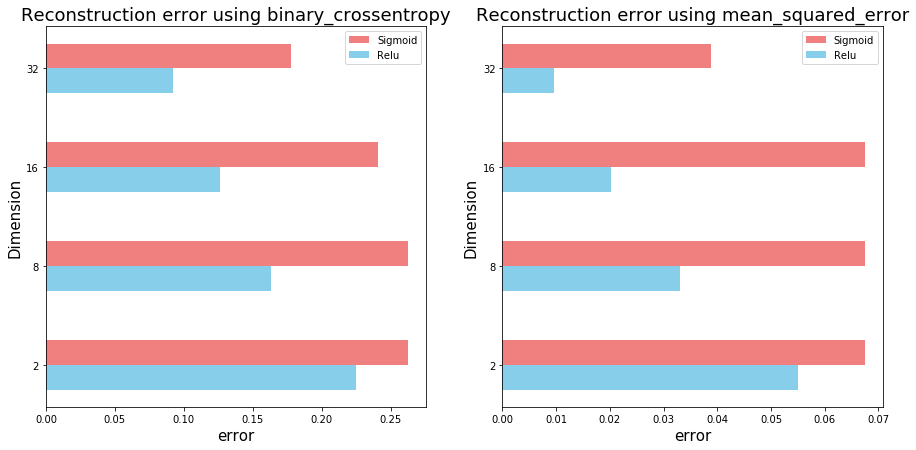

In [11]:
sig_loss, relu_loss = reconstruction_error_plot([2,4,6,8],'sigmoid',AE_sigmoid_dict,AE_relu_dict)

Se obtienen mejores resultados al utilizar la función de activación ReLu en ambos casos. También se observa que este error disminuye a medida que se aumentan las dimensiones _**en este caso**_, pues si se sigue aumentando la dimensionalidad de la representación latente se daría el caso en que el autoencoder comience a memorizar el input en vez de aprender una representación que le permita reconstruir el input.

Como ambas funciones de pérdidas tienen escalas distintas no se pueden comparar entre si. Por lo que esta comparación se realizará a partir de la visualización de los outputs más adelante.

In [9]:
def compression_plot(dim_list,activation_encoder,loss,r_loss):
    comp_size_list = []
    for dim in dim_list:
        encoder = load_model("autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation_encoder,dim))
        predict = encoder.predict(x_test)
        comp_size_list.append(1 - predict[0].nbytes/x_test[0].nbytes)
    plt.figure(figsize=(10,5))
    plt.title("Compression Rates")
    plt.ylabel("Compression rate in bytes")
    plt.xlabel("Reconstruction error")
    markers = ["h","X","d","*"]
    for index in range(len(dim_list)):
        plt.scatter(r_loss[index],
                    comp_size_list[index],
                    c=[[np.random.uniform(0.0,1.0),
                        np.random.uniform(0.0,1.0),
                        np.random.uniform(0.0,1.0)]]
                    ,label=dim_list[index]
                    ,marker=markers[index],
                   s = 200)
    plt.legend(loc='lower loc',title="Dimension")
    plt.show()
    
    

En términos del ratio de compresión al utilizar ambos autoencoders se obtiene una representación latente de la misma dimensionalidad, por lo que se mostrarán los resultados solo para los Autoencoders con Binary Crossentropy como función de pérdida. 

A continuación se presenta un gráfico del error de reconstrucción versus el ratio de compresión para cada dimensión utilizada. El ratio de compresión se calcula se la siguiente manera.

$$ 1 - \frac{\text{Bytes representación latente}}{\text{Bytes imagen original}}$$

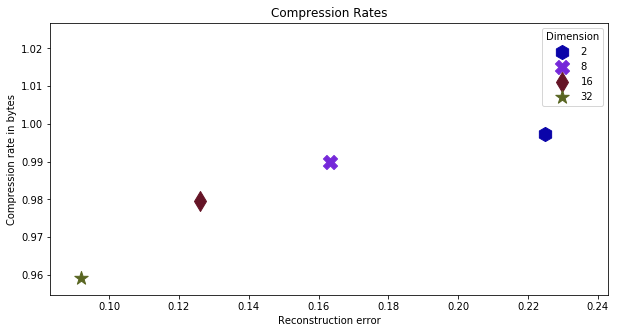

In [12]:
compression_plot(dimension_list,'relu','binary_crossentropy',relu_loss)

Como se puede observar, a medida que a más ratio de compresión mayor es el error de reconstrucción, obtenido mejores resultados con $d = 32$. Habría que seguir realizando experimentos para ver si esta tendencia se mantiene si se sigue aumentando la dimensionalidad.

> _**b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.**_

A continuación se compararán los autoencoders con respecto a la percepción visual de la reconstrucción realizada por cada AE. Se utilizarán dos imágenes para realizar esta comparación, las cuales corresponden a las primeras dos imágenes del conjunto de pruebas.

In [10]:
def comparison_plot(n_images,x_test,decoded_test,compres_dim,activation,loss):
    plt.figure(figsize=(20,4))
    for i in range(n_images):
        ax = plt.subplot(2,n_images,i+1)
        plt.title("Original Image")
        plt.imshow(x_test[i].reshape(28,28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2,n_images,i+1+n_images)
        plt.title("Decoded Image with %s dimensions, %s activation and %s loss" % (compres_dim, activation,loss))
        plt.imshow(decoded_test[i].reshape(28,28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def load_and_plot_comparison(dim_list,activation,loss,n_images):
    for dim in dim_list:
        autoencoder_model = load_model("autoencoders/basic_autoencoders/%s/%s_autoencoder_d%s.h5" % (loss,activation,dim))
        autoencoder_predict = autoencoder_model.predict(x_test)
        comparison_plot(n_images,x_test,autoencoder_predict,dim,activation,loss)

### Sigmoid activation with Binary Crossentropy

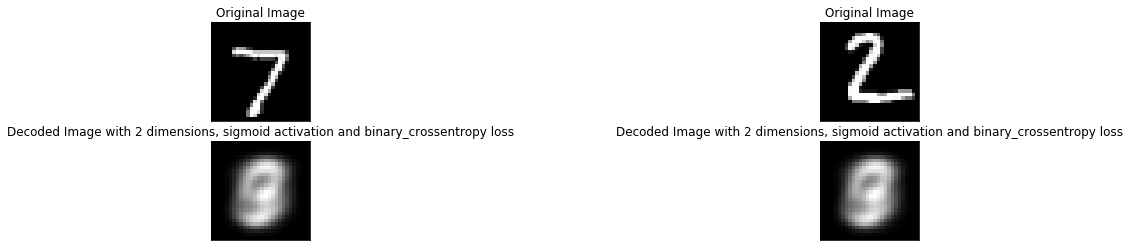

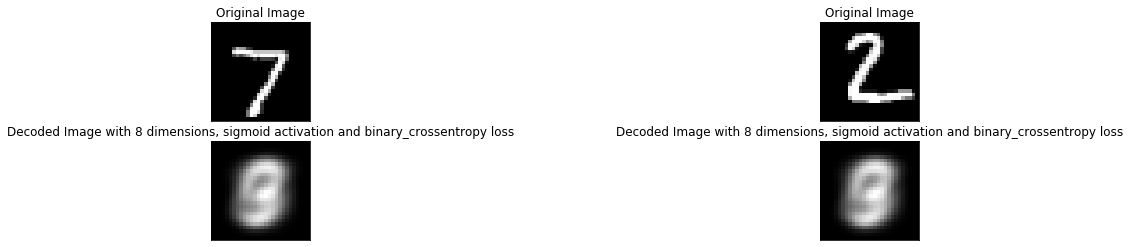

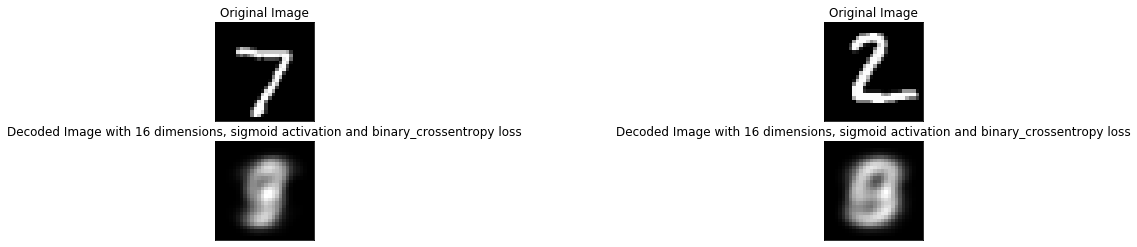

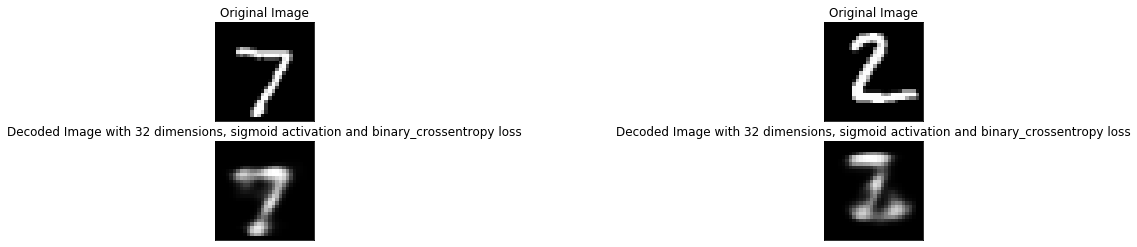

In [14]:
load_and_plot_comparison(dimension_list,'sigmoid','binary_crossentropy',2)

Al utilizar $d = 2$ se observa una reconstrucción borrosa para ambas imágenes, donde se genera lo mismo para ambas, situación que se repite para $d = 8$. Con $d = 16$ se sigue viendo borroso, pero se logra ver un ligero cambio en la reconstrucción de la primera imagen dado origen a reconstrucciones distintas para ambas imágenes. Con $d = 32$ se logra obtener algo mejor, donde se sigue viendo borroso pero se aprecia la forma de la imagen original.

En este caso se da el caso que a menor error de reconstrucción se ve mejor.

### Sigmoid Activation with Mean Squared Error

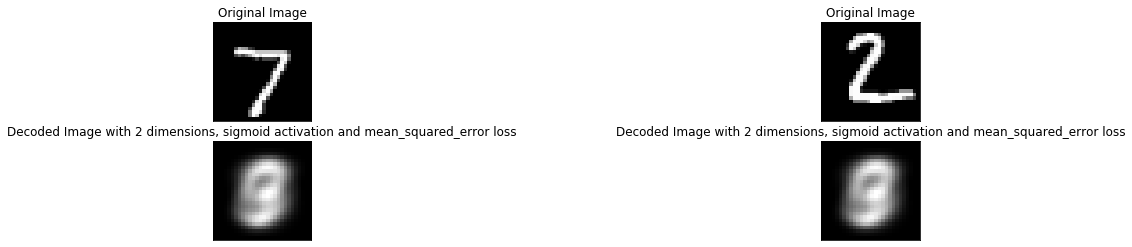

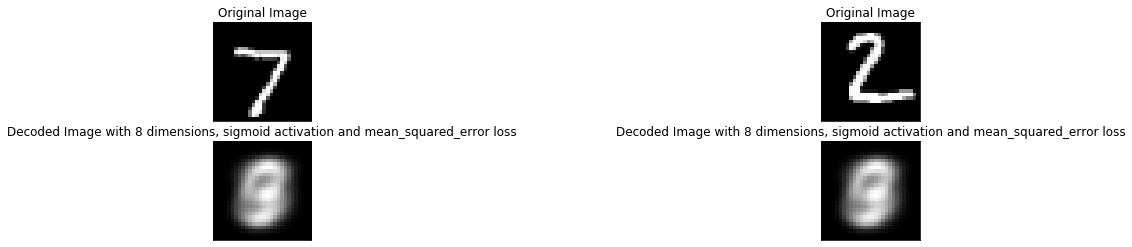

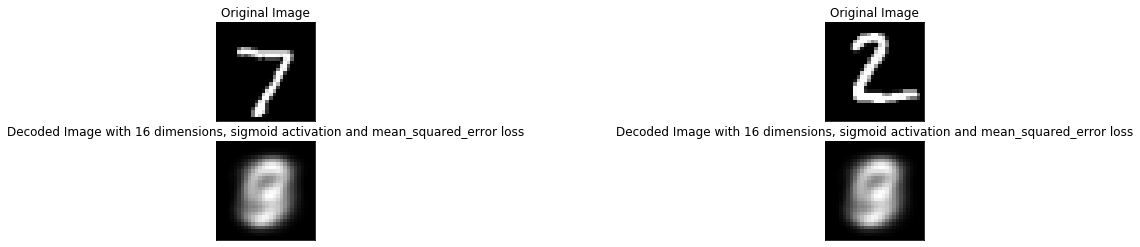

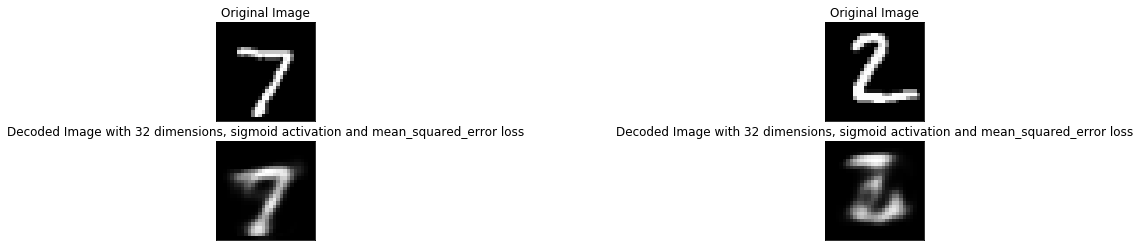

In [94]:
load_and_plot_comparison(dimension_list,'sigmoid','mean_squared_error',2)

Con esta configuración se da la misma situación que al utilizar Binary Crossentropy, salvo con $d = 16$, donde se sigue dando que la reconstrucción para ambas imágenes es la misma (caso que se da solo en $d = 2$ y $d = 4$ en el caso anterior), lo que podría indicar que el Mean Squared Error funciona de manera ligeramente inferior. Ahora, para $d = 32$ se tiene que la segunda imagen se ve ligeramente peor que en el caso anterior, pero es una observación netamente personal.

### Relu Activation with Binary Crossentropy

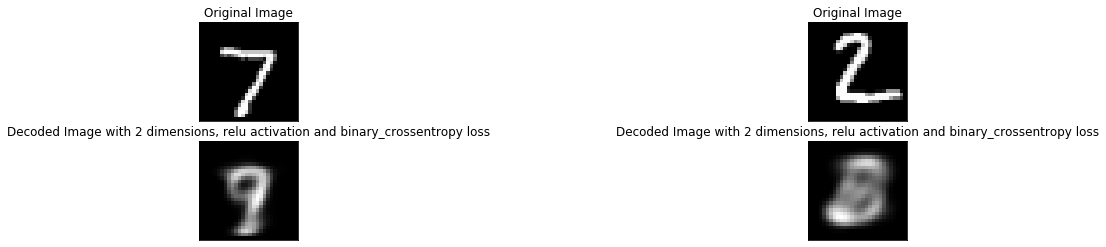

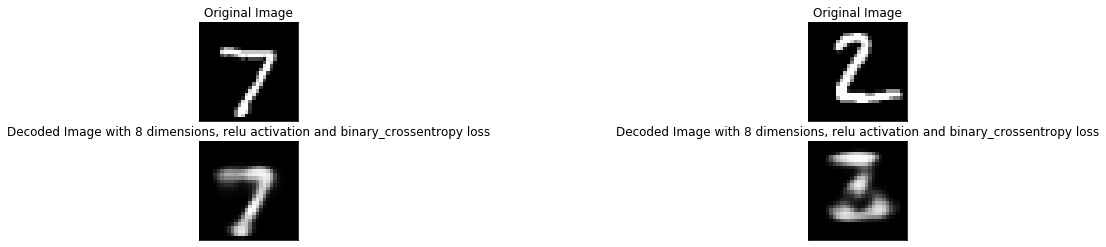

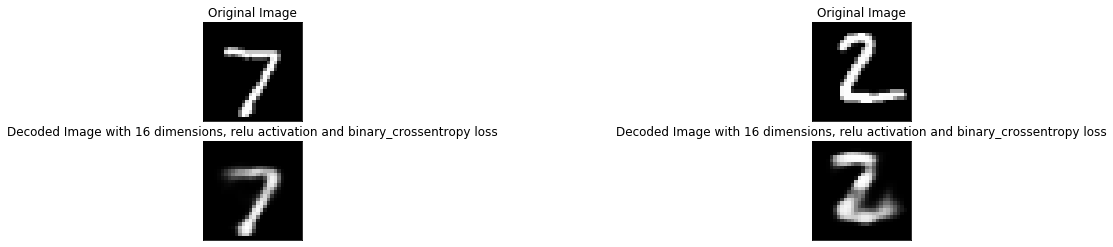

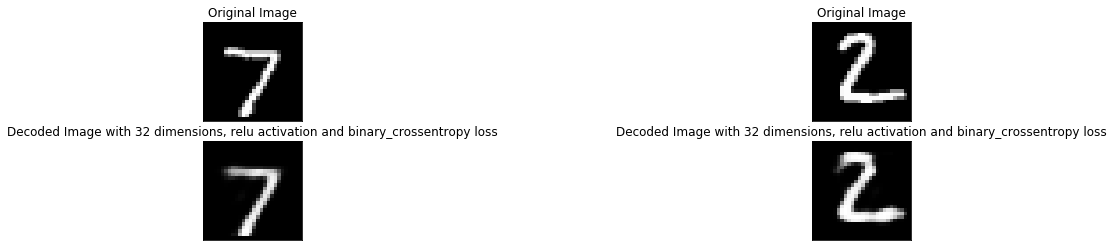

In [95]:
load_and_plot_comparison(dimension_list,'relu','binary_crossentropy',2)

En este caso, para $d = 2$ se ven reconstrucciones borrosas sin embargo son reconstrucciones distintas para ambas imágenes, donde en el caso de la primera imagen se ve la forma de un 9 en vez de un 7, lo que podría indicar que ambos dígitos están cerca en el espacio latente, probablemente debido al trazo vertical que ambos tienen. Al pasar a $d = 8$ ya se logran ver las formas originales, dando a entender que el uso de una función de activación ReLu para el encoder da mejores resultados que en el caso de la activación Sigmoidal. Con $d = 16$ se logra ver un poco menor borroso que con $d = 8$, dando paso a $d = 32$, donde se logra reconstruir el input casi perfectamente.

En este caso se corresponde el error de reconstrucción con la percepción visual.

### Relu Activation with Mean Squared Error

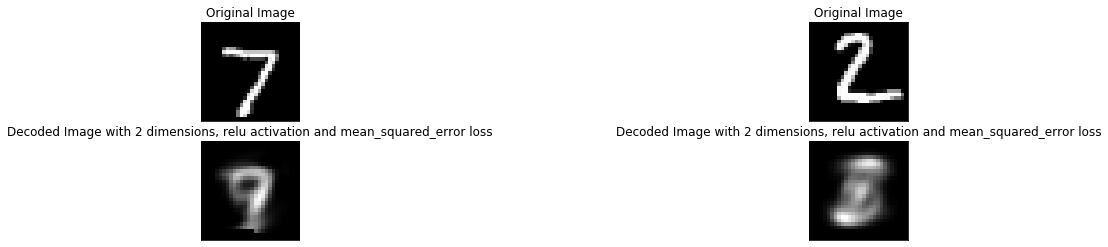

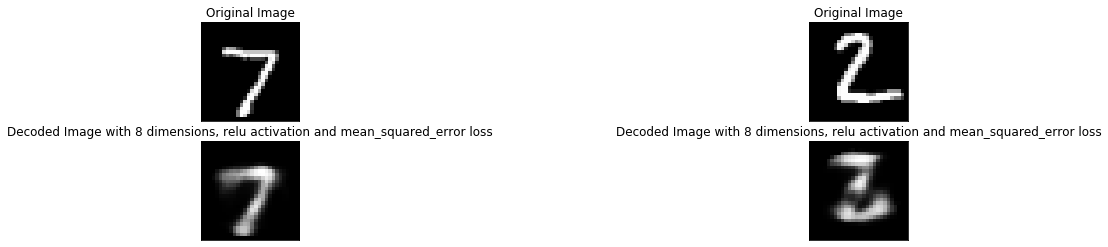

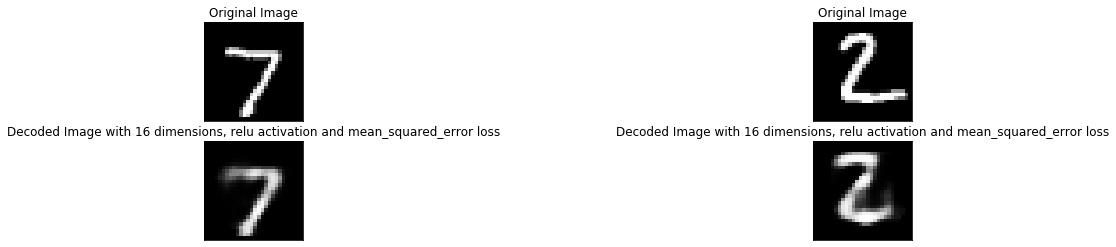

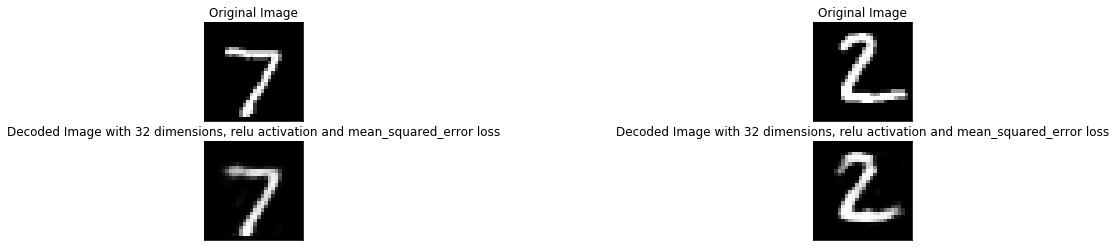

In [96]:
load_and_plot_comparison(dimension_list,'relu','mean_squared_error',2)

En este caso se observa prácticamente lo mismo que el caso anterior. Podrían haber diferencias en la forma de los trazados, donde el Autoencoder con Binary Crossentropy obtiene una representación algo mejor en el caso $d = 32$ pero menor desempeño (ligeramente) con $d = 8$.

> _**c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error, en conjunto de entrenamiento y pruebas, obtenido construyendo este clasificador sobre la data reducida a través del autoencoder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación, además de comparar los tiempos medios de predicción en ambos escenarios.**_

Se utiliza la representación obtenida para entrenar un clasificador KNN con $k = 10$.  Dado que en la comparación visual se obtienen mejores resultados al utilizar la función de activación ReLu se decide continuar solo con esta para este experimento y los futuros. Con respecto a la función de pérdida, como se obtiene resultados similares se decide continuar solo con Binary Crossentropy, principalmente por temas de tiempo para realizar el experimento con ambas funciones de pérdida.

In [11]:
def train_and_test_error(dim_list,activation,loss):
    pca_train_error = []
    pca_test_error = []
    encoder_train_error = []
    encoder_test_error = []
    pca_time_list = []
    encoder_time_list = []
    for dim in dim_list:
        #PCA
        x_train_for_pca = x_train.reshape((len(x_train),img_rows * img_cols * channel))
        x_test_for_pca = x_test.reshape((len(x_test),img_rows * img_cols * channel))
        pca_model = PCA(n_components = dim)
        pca_model.fit(x_train_for_pca)
        start_time = time.time()
        x_pca_train = pca_model.transform(x_train_for_pca)
        x_pca_test = pca_model.transform(x_test_for_pca)
        #KNN over PCA
        knn_model = KNN(10)
        knn_model.fit(x_pca_train,y_train)
        pca_train_error.append(1 - knn_model.score(x_pca_train,y_train))
        pca_test_error.append(1 - knn_model.score(x_pca_test,y_test))
        pca_time_list.append(time.time() - start_time)
        #Encoder
        encoder = load_model("autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation,dim))
        start_time = time.time()
        x_encoder_train = encoder.predict(x_train)
        x_encoder_test = encoder.predict(x_test)
        #KNN over encoder
        knn_model = KNN(10)
        knn_model.fit(x_encoder_train,y_train)
        encoder_train_error.append(1 - knn_model.score(x_encoder_train,y_train))
        encoder_test_error.append(1 - knn_model.score(x_encoder_test,y_test))
        encoder_time_list.append(time.time() - start_time)
    return pca_train_error, pca_test_error, encoder_train_error, encoder_test_error, pca_time_list, encoder_time_list    

In [12]:
def error_plot(dim_list,activation,loss):
    pca_train, pca_test, encoder_train, encoder_test, pca_time, encoder_time = train_and_test_error(dimension_list,activation,loss)
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.title("Classification Error in Train Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,pca_train,0.5,color='lightcoral',label="PCA",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_train,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.subplot(1,2,2)
    plt.title("Classification Error in Test Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,pca_test,0.5,color='lightcoral',label="PCA",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_test,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.show()
    plt.figure(figsize=(15,7))
    plt.title("Prediction times")
    plt.xlabel("Time [s]", fontsize=15)
    plt.ylabel("Dimension", fontsize=15)
    plt.barh(dim_list,pca_time,0.5,color='lightcoral',label='PCA',tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_time,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.show()
    return pca_test, encoder_test

Se compara el error de clasificación de KNN al utilizar los AE versus al uso de PCA, la cual es otra técnica no supervisada para la reducción de la dimensionalidad. Se grafica el error de clasificación versus la dimensión de la representación latente en ambos conjuntos de datos. También se presenta el tiempo de prediccion para ambas técnicas según la dimensión utilizada.

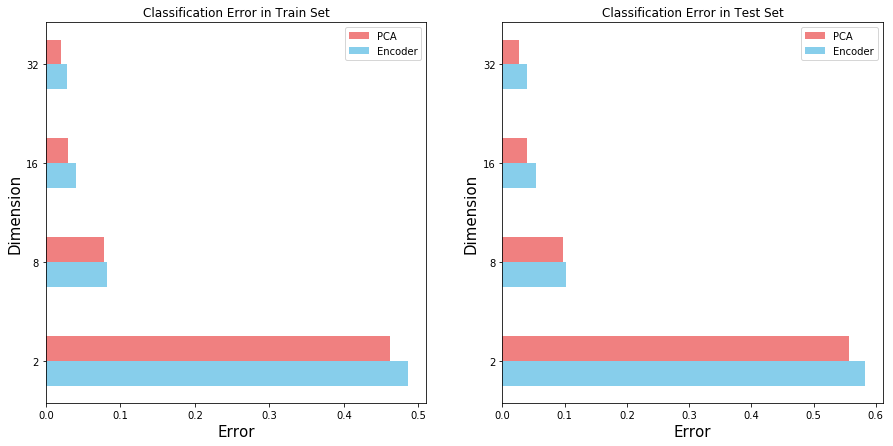

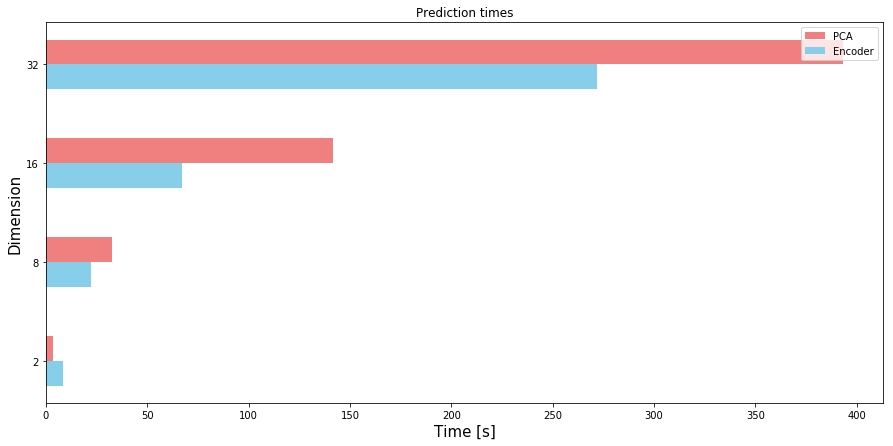

In [16]:
pca_test, encoder_test = error_plot([2,4,6,8],'relu','binary_crossentropy')

Se observa un ligero mejor desempeño al utilizar PCA con respecto al user el encoder de los AE entrenados anteriormente. En términos del tiempo de predicción, medidos desde el momento en que cada técnica comienza con las transformaciones del input, se observa que el Encoder toma mucho menor tiempo que PCA, desprendiendo que el forward pass es bastante más rápido que el descenso que realiza PCA al proyectar el input sobre las componentes principales.

> _**d) Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (más de dos capas) haciendo uso de las capas convolucionales para trabajar sobre matrices. Comente cómo sufre las transformaciones el patrón de entrada. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA y por el obtenido en (a) utilizando el mismo número de dimensiones $d'$ . Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.**_

En este experimento se entrenan Deep Autoencoders para mejorar el desempeño de los AE entrenados anteriormente. Para el Encoder se utilizan dos capas convolucionales y dos capas de MaxPooling, mientras que para el Decoder se utilizan dos capas convolucionales y dos capas de UpSampling. Para generar la representación latente se utiliza una capa Flatten seguida de una capa densa con un número de neuronas igual a la dimensión deseada para la representación latente.

In [13]:
def get_conv_deepAE(compres_dim,activation,activation_decoder,loss):
    input_img = Input(shape=original_img_size)
    print(original_img_size)
    x = Conv2D(16, (3,3),activation=activation,padding='same')(input_img)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    before_flatten = (x.shape[1].value,x.shape[2].value,x.shape[3].value)
    x = Flatten()(x)
    encode = Dense(compres_dim,activation = activation)(x)
    x = Dense(np.prod(before_flatten),activation=activation)(encode)
    x = Reshape(before_flatten)(x)
    x = Conv2D(32, (3,3), activation=activation, padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(16, (3,3), activation=activation, padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decode = Conv2D(1, (3,3), activation=activation_decoder,padding='same')(x)
    autoencoder = Model(input_img,decode)
    encoder = Model(inputs=input_img,outputs=encode)
    autoencoder.compile(optimizer='rmsprop',loss=loss)
    test_loss = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,verbose=0,validation_data=(x_test,x_test)).history['val_loss'][-1]
    return encoder, autoencoder, test_loss
    

In [14]:
def train_and_save_deepAE(dimension_list,activation_encoder,activation_decoder,loss):
    hist_list = []
    for i in dimension_list:
        encoder, autoencoder, test_loss = get_conv_deepAE(compres_dim=i,activation=activation_encoder,activation_decoder=activation_decoder,loss=loss)
        hist_list.append(test_loss)
        autoencoder.summary()
        autoencoder.save('autoencoders/deep_autoencoders/%s/%s_autoencoder_d%s.h5' % (loss,activation_encoder,i))
        encoder.save('autoencoders/deep_autoencoders/%s/%s_encoder_d%s.h5' % (loss,activation_encoder,i))
    return hist_list

A continuación se puede observar la arquitectura de los distintos deep AE entrenados. Al pasar por las capas convolucionales se puede ver que se aumenta el número de canales de la imagen, dado los filtros utilizados en estas capas. Al pasar por las capas de pooling se reduce a la mitad la dimensión de la imagen manteniendo la cantidad de filtros. Dada la arquitectura hasta este punto se genera un vector de 1568 componentes al pasar por la capa Flatten, donde la forma de el input al pasar a la siguiente capa depende netamente de la dimensión a utilizar, lo que agrega o disminuye parámetros entrenables dado que se utiliza una capa densa. Luego comienzan las capas para reconstruir el input, las cuales se construyen de tal manera que el input vaya teniendo la misma forma que tenía al pasar por las capas del encoder (pero de forma interna).

In [27]:
#NO CORRER
deep_binary = train_and_save_deepAE(dimension_list,'relu','sigmoid','binary_crossentropy')
#NO CORRER
with open('autoencoders/deep_autoencoders/hist_list/binary_cross.sav','wb') as handler:
    pickle.dump(deep_binary, handler)

(28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3138     

In [15]:
with open("autoencoders/deep_autoencoders/hist_list/binary_cross.sav","rb") as handler:
    deep_hist_list = pickle.load(handler)

In [16]:
def test_error_deep_encoder(dim_list,activation,loss):
    encoder_test_error = []
    for dim in dim_list:
        #DeepAE
        encoder = load_model("autoencoders/deep_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation,dim))
        x_encoder_train = encoder.predict(x_train)
        x_encoder_test = encoder.predict(x_test)
        #KNN over encoder
        knn_model = KNN(10)
        knn_model.fit(x_encoder_train,y_train)
        encoder_test_error.append(1 - knn_model.score(x_encoder_test, y_test))
    return encoder_test_error    

In [17]:
def classification_and_reconstruction_plot(dim_list,activation,loss,pca_test,encoder_test,deep_loss,relu_loss):
    deep_test = test_error_deep_encoder(dimension_list,activation,loss)
    plt.figure(figsize=(15,15))
    plt.subplot(211)
    plt.title("Classification Error in Test Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),pca_test,0.5,color='lightcoral',label="PCA",tick_label=['2','8','16','32'])
    plt.barh(dim_list,encoder_test,0.5,color='skyblue',label="Encoder AE",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x + 0.5,dim_list)),deep_test,0.5,color='yellowgreen',label="Encoder DeepAE",tick_label=['2','8','16','32'])
    plt.yticks([2,4,6,8])
    plt.legend(loc="upper right")
    plt.subplot(212)
    plt.title("Reconstruction Error in Test set")
    plt.xlabel("Loss",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),deep_loss,0.5,color='lightcoral',label="Deep Auto Encoder",tick_label=['2','8','16','32'])
    plt.barh(dim_list,relu_loss,0.5,color='skyblue',label="Auto Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.show()

Se realiza el mismo experimento anterior, ahora agregando el error de clasificación del Deep AE, sin considerar el tiempo de predicción. Tambié se grafica el error de reconstrucción entre el autoencoder normal y el deep autoencoder.

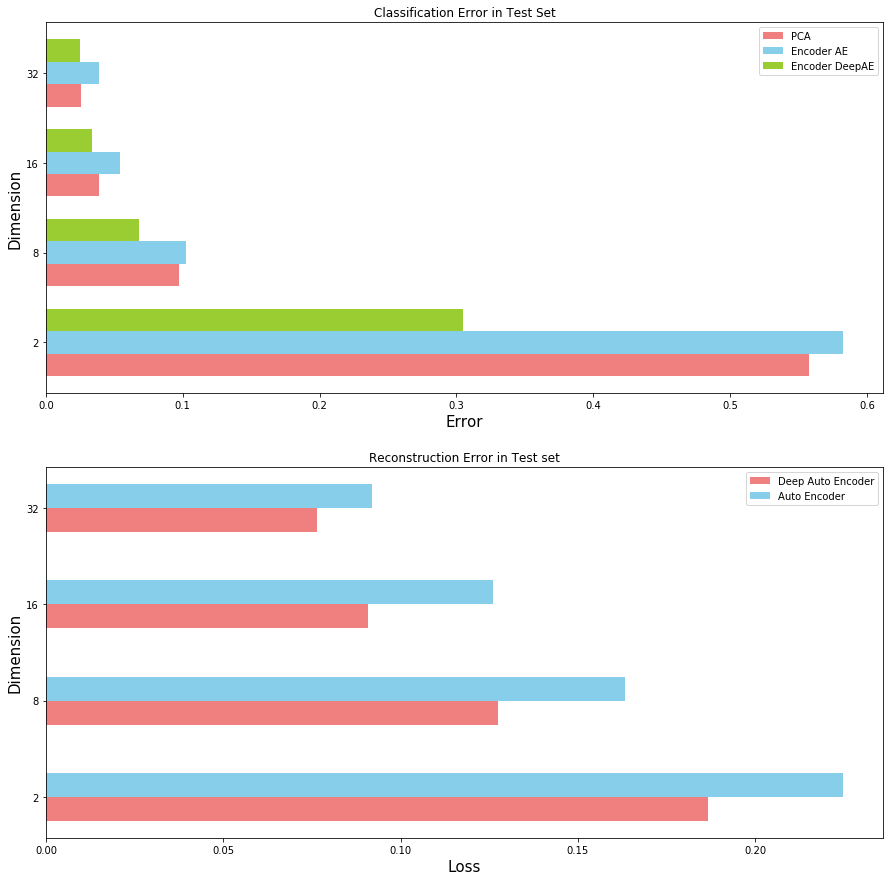

In [23]:
classification_and_reconstruction_plot([2,4,6,8],'relu','binary_crossentropy',pca_test,encoder_test,deep_hist_list,relu_loss)

Se observa que el deep AE mejor la performance en clasificación obtenida por las dos técnicas anteriores prácticamente en todas las dimensiones, obteniendo un desempeño similar que PCA al utilizar $d = 32$. También se observa que obtiene mejor error de reconstrucción que el AE normal en todas las dimensiones utilizadas. Lo anterior indica que un AE más profundo mejora el desempeño de un AE normal, al menos mientras la cantidad de parámetros y los problemas en entrenamiento lo permitan.

> _**e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes.**_

Utilizando la herramienta TSNE (sklearn) es posible visualizar un espacio de alta dimensionalidad en uno de dos dimensiones, por lo que se utiliza para visualizar las representaciones latentes del Deep AE con respecto a la generada por PCA. Como en $d = 32$ se obtienen resultados similares se decide utilizar $d = 16$ para apreciar las diferencias.

In [18]:
def tsne_plot(dim,activation,loss,nplot):
    encoder = load_model("autoencoders/deep_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation,dim))
    encoded_train = encoder.predict(x_train[:nplot])
    tsne_model = TSNE(n_components=2,random_state=42)
    encoded_train = tsne_model.fit_transform(encoded_train)
    #Begins the plot
    colors = {0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title("Latent space using convolutional deep autoencoder")
    for idx in range(0,nplot):
        label = y_train[idx]
        line = plt.plot(encoded_train[idx][0],encoded_train[idx][1],
                       color=colors[label],marker=markers[label],
                       markersize=6)
    #plt.colorbar(plt.contourf([encoded_train[:][0],encoded_train[:][1]],y_train[:nplot]))
    plt.subplot(122)
    plt.title("Latent space using PCA")
    model_pca = PCA(n_components=dim)
    x_train_pca = x_train.reshape((len(x_train),img_rows * img_cols * channel))
    model_pca.fit(x_train_pca)
    pca_train = model_pca.transform(x_train_pca)
    encoded_train = pca_train[:nplot]
    tsne_model = TSNE(n_components=2,random_state=42)
    encoded_train = tsne_model.fit_transform(encoded_train)
    for idx in range(0,nplot):
        label = y_train[idx]
        line = plt.plot(encoded_train[idx][0],encoded_train[idx][1],
                       color=colors[label],marker=markers[label],
                       markersize=6)
    plt.show()    

Se utiliza los siguiente colores para cada número para cada número.

- 0 $\rightarrow$ Azul
- 1 $\rightarrow$ Verde
- 2 $\rightarrow$ Rojo
- 3 $\rightarrow$ Celeste
- 4 $\rightarrow$ Morado
- 5 $\rightarrow$ Verde Claro
- 6 $\rightarrow$ Negro
- 7 $\rightarrow$ Naranjo
- 8 $\rightarrow$ Verde Oscuro
- 9 $\rightarrow$ Marrón

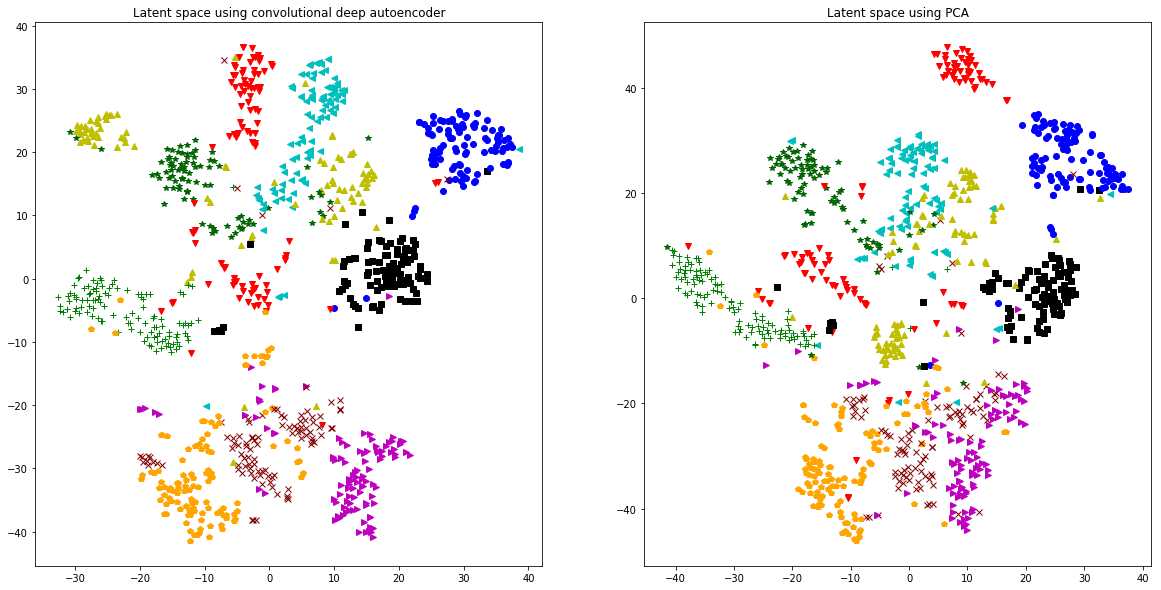

In [19]:
tsne_plot(16,'relu','binary_crossentropy',1000)

Al comparar ambos TSNE, se observa que la varianza intra-clases al utilizar PCA es mayor que al utilizar el Deep Autoencoder, donde se ve que el Deep Autoencoder las concentra más. Por otro ambas técnicas dejan relativamente cerca las clases similares, tales como el 7 - 9 - 4 (naranjo - marrón - Morado). En el caso del Deep Autoencoder también deja cerca el 2 con 8 (rojo - verde oscuro), dada la similitud que tienen ambos dígitos al escribirlos manualmente (en algunos casos), lo que podría explicar la forma borrosa de la reconstrucción para el número 2 en los experimentos de visualización. También el deep AE deja juntos el 5 y 6 (verde claro - negro).

## Variational Autoencoder tradicional

Un Variational Autoencoder (VAE) es un modelo generativo derivado de la idea de pensar tanto encoder como decoder (y prior) como probabilistas. Los VAE introducen una distribución específica para la representación latente (prior), y el gran aporte desde un punto de vista probabilístico de este método es que permite elegir la distribución del encoder arbitrariamente, cuando según la Regla de Bayes al definir $p(z)$ y $p(x|z)$ (decoder) deja amarrada la distribución del encoder.

$$ p(z|x) = \frac{p(x|z)\cdot p(z)}{p(x)}$$

Para liberar la distribución del encoder, este último aprende una distribución arbitraria $q(z|x)$ y fuerza a que esta última sea similar a $p(z)$ utilizando un regularizador, que generalmente se trata de la divergencia KL.

Desde un punto de vista más computacional, el gran aporte de los VAE es que permiten entrenar capas probabilísticas utilizando BackPropagation, cosa que logran introdución un método de sampleo desde una normal (en su forma clásica) cualquiera a una normal estándar $N(0,1)$, con lo que la generación del input del decoder pasa a ser determinista, dejando aislada la capa probabilista.

<img src='https://i.imgur.com/ZN6MyTx.png'>

> _**a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 tandas convolucionales y una *fully conected*, con una distribución Normal de 2 componentes para las variables latentes, $z \sim \mathcal{N} (\mu, \sigma^2 )$. Describa la arquitectura utilizada.**_

In [ ]:
def get_VAE_Encoder(filters,num_conv,intermediate_dim,latent_dim):
    x = Input(shape=original_img_size)
    conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same',activation='relu')(x)
    conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same',activation='relu')(conv_1)
    conv_3 = Conv2D(filters*2,kernel_size=num_conv,padding='same',activation='relu',strides=2)(conv_2)
    flat = Flatten()(conv_3)
    hidden = Dense(intermediate_dim,activation='relu')(flat)
    z_mean = Dense(latent_dim,activation='linear')(hidden)
    z_log_var = Dense(latent_dim,activation='linear')(hidden)
    encoder = Model(x,z_mean)
    encoder.summary()
    shape_before_flattening = K.int_shape(conv_3)[1:]
    return encoder, z_mean, z_log_var, shape_before_flattening,x

In [47]:
#NO CORRER
VAE_encoder, z_mean, z_log_var, shape_bf_flat, input_layer = get_VAE_Encoder(32,3,128,2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total para

La arquitectura hasta el momento cuenta con 3 capas convolucionales seguidas de la capa de entrada, donde esta última tiene un stride $= 2$ por lo que la imagen reduce sus dimensiones de 28 x 28 a 14 x 14. En este caso no se utilizan capas de MaxPooling. Luego se utiliza una capa Flatten dando origen a un vector de 12544 componentes conectada a una capa densa de 128 neuronas ,la cual está conectada a dos capas "paralelas", ambas con 2 neuronas y que representan la media y la varianza de la distribución de probabilidad que se desea obtener, en este caso una distribución normal bi-dimensional.

> _**b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y 3 tandas de la operación inversa a una convolución (Convolución transpuesta), comente cómo ésta trabaja y cómo funcionan los parámetros de *stride*.**_

Se define la sección del decoder, la cual parte a reconstruir desde la capa densa de 128 neuronas, esto es después de recibir los valores de la distribución normal.

Para generar una nueva imagen, se utilizan capas Convolucionales Transpuesta, la cual aplica la operación de convolución en la dirección opuesta de lo normal, provocando que "deshaga" los efectos de una convolución. En este caso el parámetro de Stride aumenta las dimensiones de la imagen, haciendo que se pase de una imagen de $14 x 14$ a una de $28 x 28$.

Visualmente, el efecto de la Convolución Transpuesta con stride 1 es el siguiente.

<img src="https://i.stack.imgur.com/YyCu2.gif"></img>


In [ ]:
def get_VAE_decoder_layers(filters,num_conv,intermediate_dim,shape_before_flattening):
    decoder_hid = Dense(intermediate_dim,activation='relu')
    decoder_upsample = Dense(np.prod(shape_before_flattening),activation='relu')
    decoder_reshape = Reshape(shape_before_flattening)
    decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv,
                                       padding='same',strides=2,activation='relu')
    decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,
                                       padding='same',activation='relu')
    decoder_mean_squash = Conv2DTranspose(channel,kernel_size=num_conv,padding='same',activation='sigmoid')
    return decoder_hid,decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash

In [48]:
#NO CORRER
decoder_hid, decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash = get_VAE_decoder_layers(32,3,128,shape_bf_flat)


> _**c) Defina la sección que conecta a estas dos partes a través de un muestreo explícito de la distribución Normal (con $\epsilon \sim \mathcal{N}(0,1)$ se tiene $g = \mu + \sigma \cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilístico/bayesiano. Describa el modelo completo.**_

Finalmente se conecta el encoder y el decoder. Para esto se genera una función de muestreo, la cual utiliza los valores de la media y la varianza que se obtienen a partir del encoder para generar un valor a partir de la distribución normal estandar, logrando que la entrada del decoder sea determinista y por lo tanto, entrenable este modelo vía backpropagation.

$$ \epsilon \sim N(0 , 1) \rightarrow \mu + \sigma \cdot \epsilon \rightarrow N(\mu,\sigma)$$

Esta función de muestreo se implementa utilizando una Capa Lambda de Keras, la cual permite aplicar una función al resultado de una capa. El resultado de este muestreo se conecta con la primera capa del decoder, siguiendo así todo el proceso de generación de imágenes, la cual es posible gracias al muestreo probabilístico.

In [ ]:
def sampling(args,latent_dim):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var)*epsilon

In [ ]:
def generate_VAE(latent_dim,z_mean,z_log_var,decoder_hid,decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash,input_layer):
    z = Lambda(sampling,output_shape=(latent_dim,),arguments={'latent_dim':latent_dim})([z_mean,z_log_var])
    print(z)
    hid_decoded = decoder_hid(z)
    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)
    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    vae_norm = Model(input_layer, x_decoded_mean_squash)
    vae_norm.summary()
    return vae_norm

Para terminar, se unen las 3 partes del modelo dando origen a la siguiente arquitectura.

In [49]:
#NO CORRER
vae_model = generate_VAE(2,
                         z_mean,
                         z_log_var,
                         decoder_hid,
                         decoder_upsample,
                         decoder_reshape,
                         decoder_deconv_1,
                         decoder_deconv_2,
                         decoder_mean_squash
                         ,input_layer)


Tensor("lambda_2/add:0", shape=(?, 2), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
_______________________________________________________

Donde se puede ver como la capa Lambda une encoder y decoder, donde las capas anteriores (convolucionales + flatten + densa) obtienen una media y una varianza, la cual es utilizada para muestrear un valor utilizando la normal estándar y finalmente generar una nueva imagen utilizando las capas convolucionales transpuestas. En la capa "conv2d transpose 4" se puede observar el efecto del parámetro Stride, aumentando la dimensionalidad de la imagen generada hasta el momento.

> _**d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.**_

Tal como se comentó antes, es necesario utilizar un regularizador para que $p(z)$ y $q(z|x)$ sean muy similares. El uso de la divergencia KL está motivado por el criterio de entrenamiento de los VAE.

Considerando lo siguiente:

$\text{Encoder} \rightarrow q_{\phi}(z|x)$

$\text{Prior} \rightarrow p{\phi}(z)$

$\text{Decoder} \rightarrow p_{\theta}(x|z)$

El criterio de entrenamiento es el siguiente:

$$ MAX_{\phi, \theta} \frac{1}{n}\sum_{i=1}^{n} q_{\phi}(z|x) 
ln\left(\frac{p_{\theta}(x^{(i)},z)}{q_{\phi}(z|x)}\right)$$

Donde al trabajar el criterio se obtiene lo siguiente:

$$ \sum_{i}\sum_{z} q_{\phi}(z|x)ln(p_{\theta}(x|z)) + \sum_{i}\sum_{z}  q_{\phi}(z|x) 
ln\left(\frac{p_{\theta}(x^{(i)}|z)}{p(z)}\right) $$

Donde el primer término corresponde al error de reconstrucción, la cual finalmente estará dado por la función de perdida, mientras que el segundo término tiene la forma de una divergencia, por lo que la divergencia de kullback-Leibler sirve como regularizador.

In [ ]:
def add_custom_loss(vae_model,input_layer,x_decoded_mean_squash,z_mean, z_log_var):
    choised_loss = keras.metrics.binary_crossentropy(K.flatten(input_layer),K.flatten(vae_model(input_layer)))
    reconstruction_loss = img_rows * img_cols * channel * choised_loss
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_model.add_loss(vae_loss)
    vae_model.summary()
    return vae_model

def get_custom_loss(input_layer,x_decoded_mean_squash,z_mean, z_log_var):
    choised_loss = keras.metrics.binary_crossentropy(K.flatten(input_layer),K.flatten(vae_model(input_layer)))
    reconstruction_loss = img_rows * img_cols * channel * choised_loss
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

```python
vae_model = add_custom_loss(vae_model,input_layer,decoder_mean_squash,z_mean,z_log_var)
```

> _**e) Entrene el modelo definido con los datos de MNIST entre 20 a 30 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.**_

Se entrena el modelo antes descrito utilizando un tamaño de batch de 32 ejemplos y 30 epochs.

```python
batch_size = 32
epochs = 30
vae_model.compile(optimizer='rmsprop')
vae_model.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,None))
```

```python
VAE_encoder_var = Model(input_layer,z_log_var)
VAE_encoder_var.save('autoencoders/vae/binary_crossentropy/encoder_var_d2.h5')
VAE_encoder.save('autoencoders/vae/binary_crossentropy/encoder_d2.h5')
vae_model.save('autoencoders/vae/binary_crossentropy/vae_d2.h5')
```

```python
with open('autoencoders/vae/binary_crossentropy/vae_d2_pickle.sav','wb') as handler:
    pickle.dump(vae_model, handler)
```

In [ ]:
VAE_encoder_var = load_model('autoencoders/vae/binary_crossentropy/encoder_var_d2.h5')
VAE_encoder = load_model('autoencoders/vae/binary_crossentropy/encoder_d2.h5')
#VAE_model = load_model('autoencoders/vae/binary_crossentropy/vae_d2.h5',custom_objects={'custom_loss':vae_loss})

> _**f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_i$, compare cualitativamente con la representación *TSNE* del AE tradicional. Además genere un histograma de la media y la varianza $\sigma_i^2$ de las dos componentes. Comente.**_

Se grafica la representación latente de los datos de pruebas en terminos de sus medias $\mu_{i}$, además de distintos histogramas de estas últimas.

In [ ]:
def VAE_TSNE(encoder,encoder_var):
    x_test_encoded = encoder.predict(x_test,batch_size=batch_size)
    x_test_encoded_var = encoder.predict(x_test,batch_size=batch_size)
    plt.figure(figsize=(10,10))
    plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1],c=y_test)
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(20,20))
    plt.subplot(321)
    plt.title("Histogram of mu 1")
    plt.hist(x_test_encoded[:,0])
    plt.subplot(322)
    plt.title("Histogram of mu 2")
    plt.hist(x_test_encoded[:,1])
    plt.subplot(323)
    plt.title("Histogram of sigma 1")
    plt.hist(x_test_encoded_var[:,0])
    plt.subplot(324)
    plt.title("Histogram of sigma 2")
    plt.hist(x_test_encoded_var[:,1])
    plt.subplot(325)
    plt.title("Histogram mus")
    plt.hist(x_test_encoded[:,0])
    plt.hist(x_test_encoded[:,1])
    plt.subplot(326)
    plt.title("Histogram sigmas")
    plt.hist(x_test_encoded_var[:,0])
    plt.hist(x_test_encoded_var[:,1])

In [1]:
batch_size =32
VAE_TSNE(VAE_encoder,VAE_encoder_var)

NameError: name 'VAE_TSNE' is not defined

Con respecto a la visualización del espacio latente, se observa que en el caso del VAE las diferentes clases del problema están agrupadas muy juntas entre sus pares, caso que no se da en la representación TSNE del autoencoder normal, pues existen clases que se encuentran muy dispersas por el espacio latente. Cabe destacar que al parece cada clase tiene definido su lugar en el espacio, salvo los números 9 y 4 que están algo mezclados entre sí, esto debido a que su escritura es muy similar.

Por otro lado, se ve que los histogramas de las medias están centrados en 0, lo que indica que el criterio regularizador funciona para el caso de las medias. No así para el caso de las varianzas, las cuales deberían estar centradas en 1 debido a que fue regularizada en base a la matriz identidas, pero se encuentra con más valores cercanos al 0. 

> _**g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿Qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?**_

Se generan nuevo datos mediante un generador de números aleatorios y el método de la transformada inversa. Estos son graficados según dos ejes, los que representan los inversos de los percentiles de la distribución, es decir los valores con los cuales se obtiene un cierto percentil de la función de distribución.

In [30]:
def get_generator(dim, decoder_hid, decoder_upsample, decoder_reshape, decoder_deconv_1, decoder_deconv_2, decoder_mean_squash):
    decoder_input = Input(shape=(dim,))
    _hid_decoded = decoder_hid(decoder_input)
    _up_decoded = decoder_upsample(_hid_decoded)
    _reshape_decoded = decoder_reshape(_up_decoded)
    _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
    _x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
    _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
    generator = Model(decoder_input, _x_decoded_mean_squash)
    return generator

In [ ]:
#NO CORRER
generator_model = get_generator(2,decoder_hid, decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash)


In [ ]:
#NO CORRER
generator_model.save('autoencoders/vae/binary_crossentropy/generator_d2.h5')```

In [31]:
generator_model = load_model('autoencoders/vae/binary_crossentropy/generator_d2.h5')

In [32]:
def generate_new_images(n, confidence_1, confidence_2, generator):
    image_size = img_cols
    figure = np.zeros((image_size * n, image_size * n))
    grid_x = norm.ppf(np.linspace(confidence_1,confidence_2,n))
    grid_y = norm.ppf(np.linspace(confidence_1,confidence_2,n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi,yi]])
            x_decoded =generator.predict(z_sample,batch_size=batch_size)
            figure[i * image_size: (i + 1) * image_size,
                  j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
    plt.figure(figsize=(15,15))
    plt.imshow(figure,cmap='gnuplot2')
    pos = np.arange(image_size/2,image_size*n,image_size)
    plt.yticks(pos,np.round(grid_y,1))
    plt.xticks(pos,np.round(grid_x,1))
    plt.show()
    

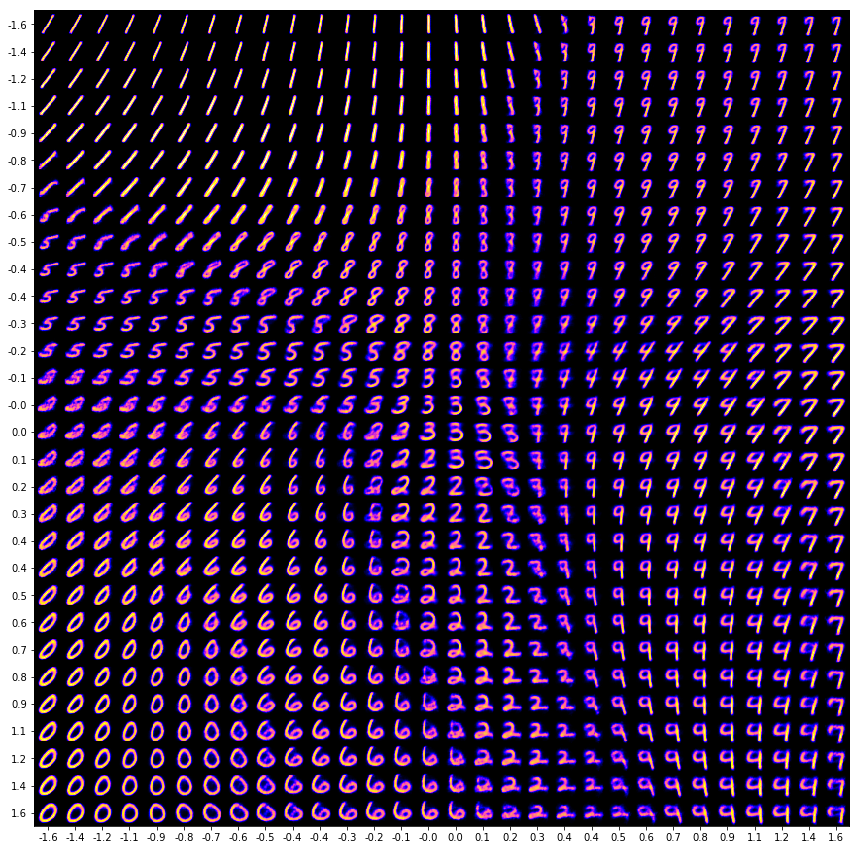

In [37]:
generate_new_images(30,0.05,0.95,generator_model)

Se logra observar como cambia la forma de los números a medida que uno se desplaza por los distintos percentiles, logrando observar en el sector inferior derecho del gráfico la mezcla entre los números 9 y 4. Cabe destacar que este gráfico se genera en el espacio del 90% de las variables latentes, que es donde se logra observar mejor la generación de dígitos.

Los siguientes dos gráficos muestra que sucede fuera de los límites del 90% de confianza.

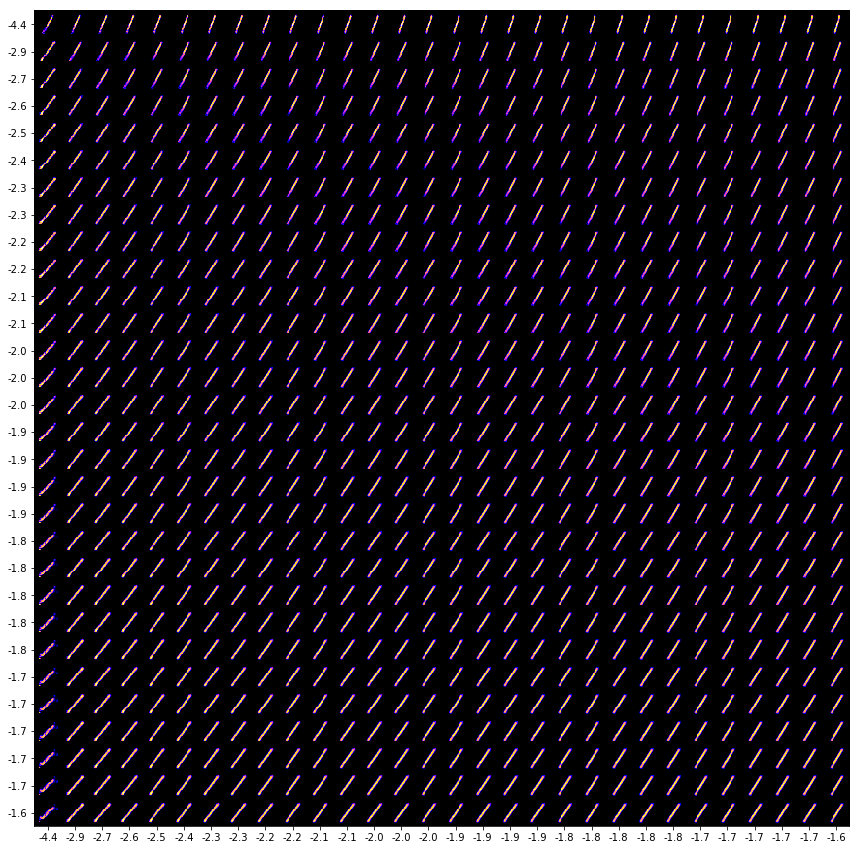

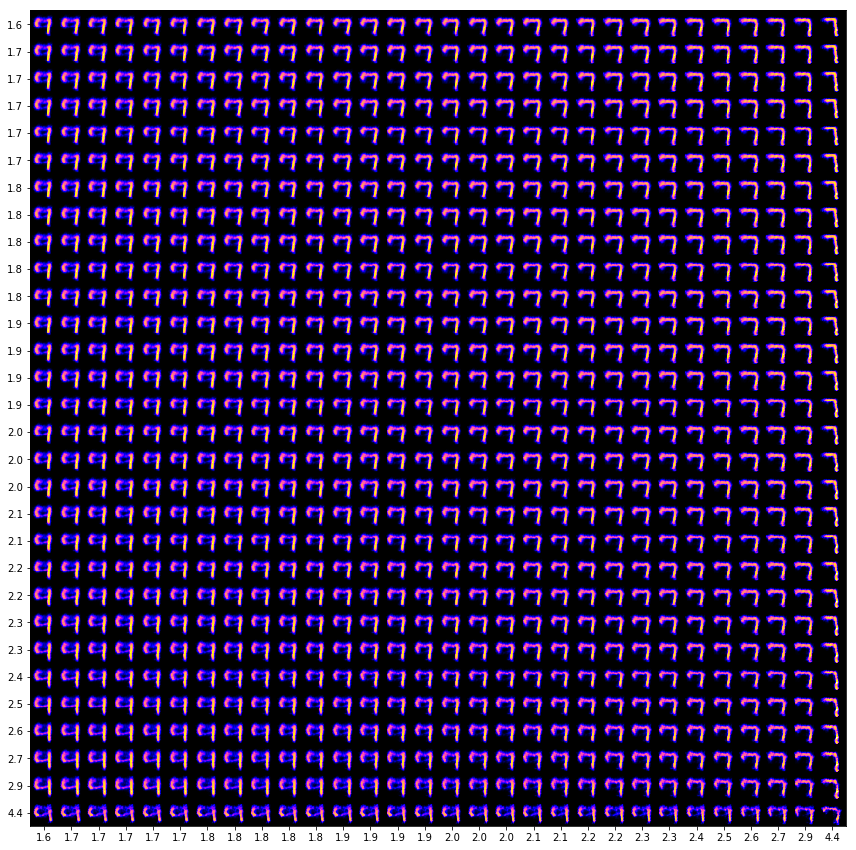

In [38]:
generate_new_images(30,0.000005,0.05,generator_model)
generate_new_images(30,0.95,0.999995,generator_model)

Se logra observar como los dígitos generados en dicho espacio no cambian en lo absoluto, generando solo 1's y solo 7's en los extremos del espacio latente.

>_**h) Experimente y comente si mejora o empeora el desempeño de clasificación de la representación encontrada al aumentar la dimensionalidad de las variables latentes $z$, contrarrestándolo con el AE tradicional ($d' = 2,8,16,32 $). Explique.**_

A continuación se realiza el mismo experimento realizado para comparar los AE con los DeepAE. Como en este caso la representación latente genera una codificación para dos parámetros distintos de una distribución, se utilizará solo la media para entrenar el clasificador KNN, pues así ambos métodos tendrán una representación latente de la misma dimensionalidad.

Primero se construyen y se entrenan los VAE con las dimensiones necesarias para realizar la comparación.

In [33]:
def train_vae(dim_list):
    for dim in dim_list:
        VAE_encoder, z_mean, z_log_var, shape_bf_flat, input_layer = get_VAE_Encoder(32,3,128,dim)
        decoder_hid, decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash = get_VAE_decoder_layers(32,3,128,shape_bf_flat)
        vae_model = generate_VAE(dim,
                         z_mean,
                         z_log_var,
                         decoder_hid,
                         decoder_upsample,
                         decoder_reshape,
                         decoder_deconv_1,
                         decoder_deconv_2,
                         decoder_mean_squash
                         ,input_layer)
        vae_model = add_custom_loss(vae_model,input_layer,decoder_mean_squash,z_mean,z_log_var)
        batch_size = 32
        epochs = 30
        vae_model.compile(optimizer='rmsprop')
        vae_model.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,None))
        VAE_encoder_var = Model(input_layer,z_log_var)
        VAE_encoder_var.save('autoencoders/vae/binary_crossentropy/encoder_var_d%s.h5' % dim)
        VAE_encoder.save('autoencoders/vae/binary_crossentropy/encoder_d%s.h5' % dim)

```python
train_vae([8, 16, 32])
```

Luego, se grafica el error de clasificación de los AE básicos y el de los VAE, para ambos conjuntos de datos, considerando las 4 dimensiones a evaluar.

In [34]:
def get_class_errors(dim_list, activation, loss):
    ae_train_error = []
    ae_test_error = []
    vae_train_error = []
    vae_test_error = []
    for dim in dim_list:
        ae_encoder = load_model("autoencoders/basic_autoencoders/{}/{}_encoder_d{}.h5".format(loss,activation,dim))
        vae_encoder = load_model("autoencoders/vae/{}/encoder_d{}.h5".format(loss,dim))
        #AE with KNN
        ae_train = ae_encoder.predict(x_train)
        ae_test = ae_encoder.predict(x_test)
        knn_model = KNN(10)
        knn_model.fit(ae_train,y_train)
        ae_train_error.append(1 - knn_model.score(ae_train,y_train))
        ae_test_error.append(1 - knn_model.score(ae_test,y_test))
        #VAE with KNN
        vae_train = vae_encoder.predict(x_train)
        vae_test = vae_encoder.predict(x_test)
        knn_model = KNN(10)
        knn_model.fit(vae_train,y_train)
        vae_train_error.append(1 - knn_model.score(vae_train,y_train))
        vae_test_error.append(1 - knn_model.score(vae_test,y_test))
    return ae_train_error, ae_test_error, vae_train_error, vae_test_error

In [35]:
def vae_ae_plot_error(dim_list,activation,loss):
    ae_train, ae_test, vae_train, vae_test = get_class_errors(dimension_list,"relu","binary_crossentropy")
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.title("Classification Error in Train Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,ae_train,0.5,color='lightcoral',
             label="AE",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),vae_train,
             0.5,color='skyblue',label='VAE',tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.title("Classification Error in Test Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,ae_test,0.5,color='lightcoral',
             label="AE",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),vae_test,
             0.5,color='skyblue',label='VAE',tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc='upper right')
    

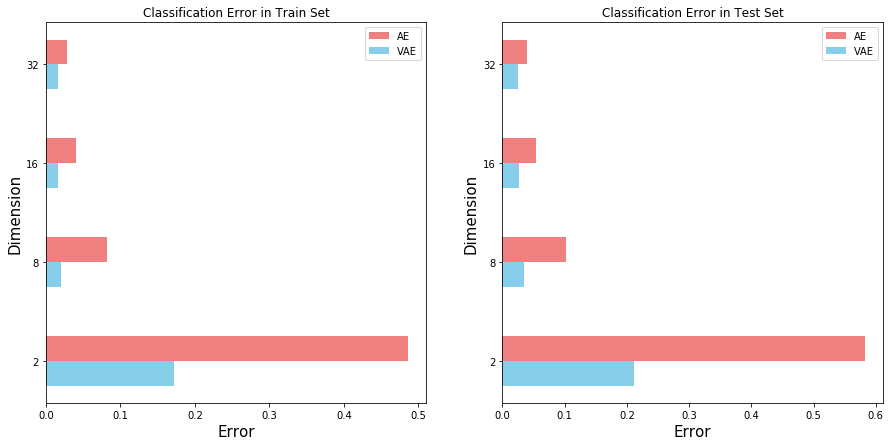

In [46]:
#NO CORRER
vae_ae_plot_error([2,4,6,8],'relu','binary_crossentropy')

Se puede observar como el VAE obtiene mejores resultados en los dos conjuntos de entrenamiento y en todas las dimensiones, por lo que a pesar de ser utilizado cómo método generativo tiene más poder como reductor de la dimensionalidad que un AE normal.

A continuación se comparará con los Deep Auto Encoders.

In [1]:
def get_class_deep_errors(dim_list, activation, loss):
    ae_train_error = []
    ae_test_error = []
    vae_train_error = []
    vae_test_error = []
    for dim in dim_list:
        ae_encoder = load_model("autoencoders/deep_autoencoders/{}/{}_encoder_d{}.h5".format(loss,activation,dim))
        vae_encoder = load_model("autoencoders/vae/{}/encoder_d{}.h5".format(loss,dim))
        #AE with KNN
        ae_train = ae_encoder.predict(x_train)
        ae_test = ae_encoder.predict(x_test)
        knn_model = KNN(10)
        knn_model.fit(ae_train,y_train)
        ae_train_error.append(1 - knn_model.score(ae_train,y_train))
        ae_test_error.append(1 - knn_model.score(ae_test,y_test))
        #VAE with KNN
        vae_train = vae_encoder.predict(x_train)
        vae_test = vae_encoder.predict(x_test)
        knn_model = KNN(10)
        knn_model.fit(vae_train,y_train)
        vae_train_error.append(1 - knn_model.score(vae_train,y_train))
        vae_test_error.append(1 - knn_model.score(vae_test,y_test))
    return ae_train_error, ae_test_error, vae_train_error, vae_test_error

In [2]:
def vae_dae_plot_error(dim_list,activation,loss):
    ae_train, ae_test, vae_train, vae_test = get_class_deep_errors(dimension_list,"relu","binary_crossentropy")
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.title("Classification Error in Train Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,ae_train,0.5,color='lightcoral',
             label="Deep AE",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),vae_train,
             0.5,color='skyblue',label='VAE',tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.title("Classification Error in Test Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,ae_test,0.5,color='lightcoral',
             label="Deep AE",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),vae_test,
             0.5,color='skyblue',label='VAE',tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc='upper right')

In [ ]:
vae_dae_plot_error([2,4,6,8],'relu','binary_crossentropy')

## Variational Autoencoder Categórico

El último autoencoder del experimento correponde a un autoencoder categórico. En este, se cambia la manera en que se modelan las variables latente a una distribución Multinomial, lo que permite representar variables categóricas. Como se trata de un modelo de aprendizaje no supervisado las categóricas encotraras con este VAE pueden no corresponderse con las categorías reales, las cuales se tiene la suerte de poseer. Como conocemos la cantidad, se utilizan 10 variables latentes correspondientes a 10 dígitos, pero en caso de ser desconocidas el número debe ser determinado de otro modo, probablemente por intuición.

> _**a) En primer lugar deberá definir la arquitectura realizando unos cambios leves a la presentada anteriormente. Comente las diferencias sobre los parámetros obtenidos.**_

Se cambia la arquitectura en sus tres secciones para que se adapte a este nuevo modelamiento.

### Encoder Layers

En el caso del encoder se altera la última capa, la cual pasa de 2 capas a una sola que modela los _logits_ de la función a aproximar.

In [36]:
def get_VAECAT_encoder(filters,num_conv,intermediate_dim,latent_dim):
    x = Input(shape=original_img_size)
    conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same',activation='relu')(x)
    conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same',activation='relu')(conv_1)
    conv_3 = Conv2D(filters*2,kernel_size=num_conv,padding='same',activation='relu',strides=2)(conv_2)
    flat = Flatten()(conv_3)
    hidden = Dense(intermediate_dim,activation='relu')(flat)
    logits_z = Dense(latent_dim,activation='linear')(hidden)
    encoder = Model(x, logits_z)
    encoder.summary()
    shape_before_flattening = K.int_shape(conv_3)[1:]
    return encoder, logits_z, shape_before_flattening,x

In [106]:
#NO CORRER
categorical_encoder, logits_z, shape_before_flattening, input_layer = get_VAECAT_encoder(32,3,128,10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total para

Lo parámetros cambian, pues en lugar de tener dos capas con 2 neuronas cada una se pasa a tener una capa con 10 neuronas, pasando de 516 parámetros a 1290 parámetros para obtener la representación latente.

### Decoder Layers

En este caso el decoder no cambia su arquitectura, pues va a recibir el valor que espera previo sampleo con las variable latentes que entrega el decoder.

In [37]:
def get_VAECAT_decoder_layers(filters,num_conv,intermediate_dim,shape_before_flattening):
    decoder_hid = Dense(intermediate_dim,activation='relu')
    decoder_upsample = Dense(np.prod(shape_before_flattening),activation='relu')
    decoder_reshape = Reshape(shape_before_flattening)
    decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv,
                                       padding='same',strides=2,activation='relu')
    decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,
                                       padding='same',activation='relu')
    decoder_mean_squash = Conv2DTranspose(channel,kernel_size=num_conv,padding='same',activation='sigmoid')
    return decoder_hid,decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash

In [108]:
#NO CORRER
decoder_hid, decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash = get_VAECAT_decoder_layers(32,3,128,shape_before_flattening)

### Gumbel-Softmax Sampling

La manera en que se muestrea cambia, pasando a usar el método conocido como _**Gumbel-Softmax Sampling**_, el cual sirve como un método para re-parametrizar distribuciones categóricas, el cual tiene su utilidad en que permite ser utilizada en casos discretos, pues con otros métodos de re-parametrización se está limitado a casos continuos.

Este método permite re-parametrizar tomando muestras desde una distribución uniforme $U(0,1)$, de la siguiente manera.

$$ G = -log(-log(u)) \rightarrow u \sim U(0,1)$$

In [89]:
# def custom_softmax(x):
#     return K.reshape(K.exp(x)/K.sum(K.exp(x)),(10,-1))

In [38]:
def sample_gumbel(shape,eps=K.epsilon()):
    U = K.random_uniform(shape, 0, 1)
    return - K.log(-K.log(U + eps) + eps)

In [39]:
import tensorflow as tf
def sampling_cat(logits_z):
    tau = K.variable(2/3, name="temperature")
    z = logits_z + sample_gumbel(K.shape(logits_z))
    return tf.nn.softmax(z/tau )

In [40]:
def generate_VAECAT(latent_dim,logits_z,decoder_hid,decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash,input_layer):
    z = Lambda(sampling_cat,output_shape=(latent_dim,))(logits_z)
    print(z)
    hid_decoded = decoder_hid(z)
    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)
    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    vae_norm = Model(input_layer, x_decoded_mean_squash)
    vae_norm.summary()
    return vae_norm

In [112]:
#NO CORRER
vaecat_model = generate_VAECAT(10,
                         logits_z,
                         decoder_hid,
                         decoder_upsample,
                         decoder_reshape,
                         decoder_deconv_1,
                         decoder_deconv_2,
                         decoder_mean_squash
                         ,input_layer)

Tensor("lambda_22/Softmax:0", shape=(?, 10), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_19 (Dense)

### Add Custom Loss

Finalmente se cambia la función de pérdida, debido que ahora se debe cambiar el regularizado a utilizar por uno ad-hoc a la distribución Multinomial con probabilidad uniforme.

In [41]:
def add_custom_loss_cat(vae_model,input_layer,x_decoded_mean_squash,logits_z):
    choised_loss = keras.metrics.binary_crossentropy(K.flatten(input_layer),K.flatten(vae_model(input_layer)))
    reconstruction_loss = img_rows * img_cols * channel * choised_loss
    dist = tf.nn.softmax(logits_z)
    dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
    kl_disc_loss = np.log(10) + dist_neg_entropy
    vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
    vae_model.add_loss(vae_loss)
    vae_model.summary()
    return vae_model

Este regularizador surge de considerar $p(z)$ como una distribución multinomial, donde también se considera una variable de peso $log 10$ para pesar cada variable encontrada. El uso de $log(10)$, termino no entrenable fuerza a que el modelo intente disminuir el negativo de la entropía, y por consiguiente aproximar los _logits_ de una distribución multinomial uniforme.

In [115]:
#NO CORRER
vaecat_model = add_custom_loss_cat(vaecat_model,input_layer,decoder_mean_squash,logits_z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
__________

> _**b) Entrene el VAE categórico de la misma manera que realizó con el VAE tradicional en (e) ¿Nota algún cambio en este paso?**_

Se entrena el VAE categorico de la misma manera en que fue entrenado el VAE anterior. Dado el tiempo que se demora en entrenar este modelo se dejó entrenando mientras el experimentador realizaba otras cosas. Sin embargo si es noto que la convergencia del entrenamiento en términos de la loss function es mucho más lento en comparación al VAE clásico.

In [116]:
#NO CORRER
batch_size = 32
epochs = 30
vaecat_model.compile(optimizer='rmsprop')
vaecat_model.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 224s 4ms/step - loss: 210.0994 - val_loss: 208.2783
Epoch 2/30
60000/60000 [==============================] - 225s 4ms/step - loss: 208.6770 - val_loss: 208.4319
Epoch 3/30
60000/60000 [==============================] - 224s 4ms/step - loss: 208.6034 - val_loss: 208.4578
Epoch 4/30
60000/60000 [==============================] - 225s 4ms/step - loss: 208.5709 - val_loss: 208.2721
Epoch 5/30
60000/60000 [==============================] - 224s 4ms/step - loss: 208.5425 - val_loss: 208.3121
Epoch 6/30
60000/60000 [==============================] - 226s 4ms/step - loss: 208.5343 - val_loss: 208.2800
Epoch 7/30
60000/60000 [==============================] - 225s 4ms/step - loss: 208.5255 - val_loss: 208.4930
Epoch 8/30
60000/60000 [==============================] - 224s 4ms/step - loss: 208.4913 - val_loss: 208.1445
Epoch 9/30
60000/60000 [==============================] - 224s 4ms/ste

### Generator

In [118]:
#NO CORRER
gen_model = get_generator(10,decoder_hid, decoder_upsample,decoder_reshape,decoder_deconv_1,decoder_deconv_2,decoder_mean_squash)


### Guardar modelos

In [119]:
#NO CORRER
categorical_encoder.save('autoencoders/vae/binary_crossentropy/encoder_cat_d2.h5')
gen_model.save('autoencoders/vae/binary_crossentropy/generator_cat_d2.h5')

### Load Models

In [42]:
gen_model = load_model('autoencoders/vae/binary_crossentropy/generator_cat_d2.h5')


In [47]:
encoder_cat = load_model('autoencoders/vae/binary_crossentropy/encoder_cat_d2.h5')

> _**c) Para ver la efectividad del encoder en lograr capturar las clases es necesario medir una métrica de desempeño, sin embargo, las métricas clásicas como *accuracy* o *f1 score* no corresponderían a este caso debido a que las categoría capturada por el encoder no debería estar en el mismo orden de la clase real, ya que fue un entrenamiento no supervisado ¿Cómo se podría cambiar ésto?. Con esto en mente mida alguna métrica de clustering sobre las categorías inferidas por el VAE. Comente.**_  

Como el VAE es no supervisado es probable que el encoder no haya capturado las clases reales del conjunto de entrenamiento, por lo que s necesario medir alguna métrica que permita medir que tan dispares son entre sí. Aprovechando que se cuenta con las clases reales, es posible utilizar métricas de clustering basadas en las etiquetas de los datos. A continuación se evaluan 4 distintas métricas asociadas a clustering.

In [46]:
def softmax(x):
    e_x = np.exp(x - x.max(axis=-1,keepdims=True))
    return e_x/e_x.sum(axis=-1,keepdims=True)

In [48]:
p_z_train = softmax(encoder_cat.predict(x_train))
p_z_test = softmax(encoder_cat.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)

#### Información Mutua

La información mutua mide que tanta información contiene una variable de otra, en este caso se utiliza una versión normalizada que por alguna razón, probablemente asociada a la implementación de sklearn, entrega un valor mayor a 1 en el conjunto de entrenamiento. En el conjunto de pruebas está a la mitad, dando a entender que las categorías predichas contienen algo de las categorías reales, pero sin acercarse demasiado.

In [65]:
print(normalized_mutual_info_score(y_train,y_train_pred))
print(normalized_mutual_info_score(y_test,y_test_pred))

0.5
3.5


#### Homogeneity Score

Esta métrica mide si los cluster encontrados solo contienen ejemplos de una sola clase. En este contexto, mide si las categorías encontradas se corresponden totalmente con alguna de las categorías reales.

In [64]:
print(homogeneity_score(y_train,y_train_pred))
print(homogeneity_score(y_test,y_test_pred))

4.824625075026512e-17
3.377693763033798e-16


Su rango va entre 0 y 1, siendo 1 el valor para una perfecta homogeneidad, por lo que al observar los valores obtenidos se da a entender que las categorías no son para nada similares a las reales. 

#### Completeness Score

La siguiente métrica mide si todos los elementos de una misma etiqueta pertenecen a un mismo cluster. Tiene un rango entre 0 y 1, donde uno indica que hay un etiquetado perfecto para una clase en un cluster.

In [63]:
print(completeness_score(y_train,y_train_pred))
print(completeness_score(y_test,y_test_pred))

1.0
1.0


Como se puede observar, se obtiene 1 en ambos conjuntos de datos, lo que indica que todos los datos pertenecen a la misma categoría, lo que explica también los malos valores del homogeneity score.

#### Fowlkes Mallows Score

Finalmente, esta métrica utiliza la media geométrica entre recall y precision, siendo utiliada para medir la similaridad entre dos cluster. 

In [62]:
print(fowlkes_mallows_score(y_train,y_train_pred))
print(fowlkes_mallows_score(y_test,y_test_pred))

0.31665938166613306
0.31663929958961895


Al igual que las otras métricas, tiene valores entre 0 y 1 con uno su valor máximo, por lo que se prevee que las categorías capturadas por el encoder no son buenas.

> _**d) Para entender mejor las categorías inferidas por el VAE genere datos "activando" una categoría y luego realizando un forward pass sobre el decoder/generador. Comente cualitativamente.**_

Para observar mejor lo inferido en el item anterior se generan datos activando una categoría, lo que implica realizar una predicción dandole valor a un logits. En teoría debería obtenerse un representante de cada categoría, pero tal como se pensaba en la evaluación mediante métricas, las categorías capturadas dejan bastante que desean, siendo prácticamente iguales salvo por unas diferencias en los puntos negros que aparecen en cada categorías.

In [52]:
def activate_categories_plot(generator,latent_dim):
    predictions = np.zeros((img_cols * 1, img_cols*latent_dim))
    for i in range(latent_dim):
        activate_aux = np.zeros((1,10))
        activate_aux[:,i] = 1
        predictions[:,i*img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
    plt.figure(figsize=(10,10))
    plt.imshow(predictions,cmap='gnuplot2')
    pos = np.arange(img_cols/2,img_cols*latent_dim,img_cols)
    plt.xticks(pos,range(latent_dim))
    plt.show()

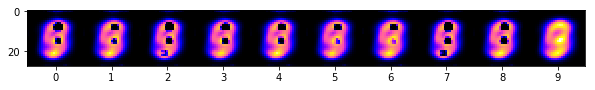

In [56]:
activate_categories_plot(gen_model,10)

> _**e) Genere algunas imágenes aleatorias, comente cualitativamente con lo obtenido con el VAE tradicional ¿Cuál pareciera ser mejor para generar datos? ¿Por qué?**_

Se genera nuevas imágenes a partir de un vector siguiendo una distribución uniforme. Tal como sucedió en el item anterior, los dígitos generados no tienen forma lógica alguna, por lo que no tiene sentido comparar este método, en el cual probablemente se cometió algún error al definir la loss function y/o el método de sampleo, contra el VAE clásico que si entrega dígitos al generar nuevas imágenes.

In [93]:
def gen_imgs_plot(generator,latent_dim):
    for j in range(5):
        predictions = np.zeros((img_cols * 1, img_cols*latent_dim))
        for i in range(latent_dim):
            activate_aux = np.random.uniform(0,1,(1,10))
            predictions[:,i*img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
        plt.figure(figsize=(10,10))
        plt.imshow(predictions,cmap='gnuplot2')
        plt.show()

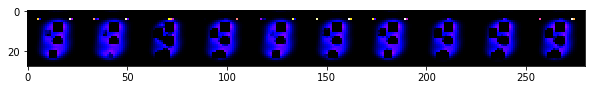

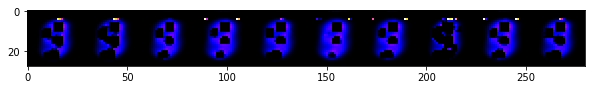

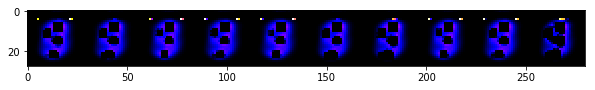

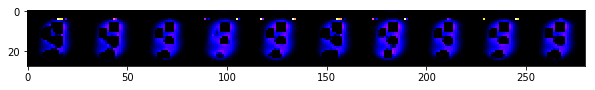

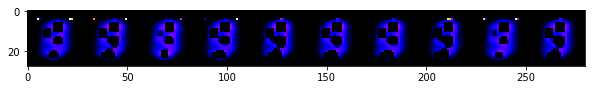

In [94]:
gen_imgs_plot(gen_model,10)